<a href="https://colab.research.google.com/github/007viswa/Hepatitis_Severity/blob/main/hepattis_with_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data"
column_names = ['Class', 'Age', 'Sex', 'Steroid', 'Antivirals', 'Fatigue', 'Malaise', 'Anorexia',
                'LiverBig', 'LiverFirm', 'SpleenPalpable', 'Spiders', 'Ascites', 'Varices',
                'Bilirubin', 'AlkPhosphate', 'Sgot', 'Albumin', 'Protime', 'Histology']

data = pd.read_csv(url, names=column_names)

In [ ]:
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)

In [ ]:
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [ ]:
def severity_grading(row):
    if row['Bilirubin'] > 2.0 or row['Sgot'] > 200 or row['Albumin'] < 3.0:
        return 'Severe'
    elif row['Bilirubin'] > 1.2 or row['Sgot'] > 100:
        return 'Moderate'
    else:
        return 'Mild'

In [ ]:
data['Severity'] = data.apply(severity_grading, axis=1)

In [ ]:
severity_encoder = LabelEncoder()
data['Severity'] = severity_encoder.fit_transform(data['Severity'])

In [ ]:
X = data.drop(['Class', 'Severity'], axis=1)
y = data['Severity']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
print(y_train.value_counts())

Severity
2    60
1     2
0     2
Name: count, dtype: int64


In [ ]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print(pd.Series(y_resampled).value_counts())

Severity
2    60
1    60
0    60
Name: count, dtype: int64


In [ ]:
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

In [ ]:
print("Full dataset class distribution:")
print(y.value_counts())

print("Train set class distribution:")
print(pd.Series(y_train).value_counts())

print("Test set class distribution:")
print(pd.Series(y_test).value_counts())

Full dataset class distribution:
Severity
2    75
0     3
1     2
Name: count, dtype: int64
Train set class distribution:
Severity
2    60
1     2
0     2
Name: count, dtype: int64
Test set class distribution:
Severity
2    15
0     1
Name: count, dtype: int64


In [ ]:
labels = [0, 1, 2]  # Assuming 0 = Mild, 1 = Moderate, 2 = Severe

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf, labels=labels))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=severity_encoder.classes_, labels=labels))

print("\nRandom Forest Accuracy Score:", rf_accuracy)

Random Forest Confusion Matrix:
[[ 0  0  1]
 [ 0  0  0]
 [ 0  0 15]]

Random Forest Classification Report:
              precision    recall  f1-score   support

        Mild       0.00      0.00      0.00         1
    Moderate       0.00      0.00      0.00         0
      Severe       0.94      1.00      0.97        15

    accuracy                           0.94        16
   macro avg       0.31      0.33      0.32        16
weighted avg       0.88      0.94      0.91        16


Random Forest Accuracy Score: 0.9375


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

In [ ]:
print(classification_report(y_test, y_pred_rf, target_names=severity_encoder.classes_, labels=labels, zero_division=0))


              precision    recall  f1-score   support

        Mild       0.00      0.00      0.00         1
    Moderate       0.00      0.00      0.00         0
      Severe       0.94      1.00      0.97        15

    accuracy                           0.94        16
   macro avg       0.31      0.33      0.32        16
weighted avg       0.88      0.94      0.91        16



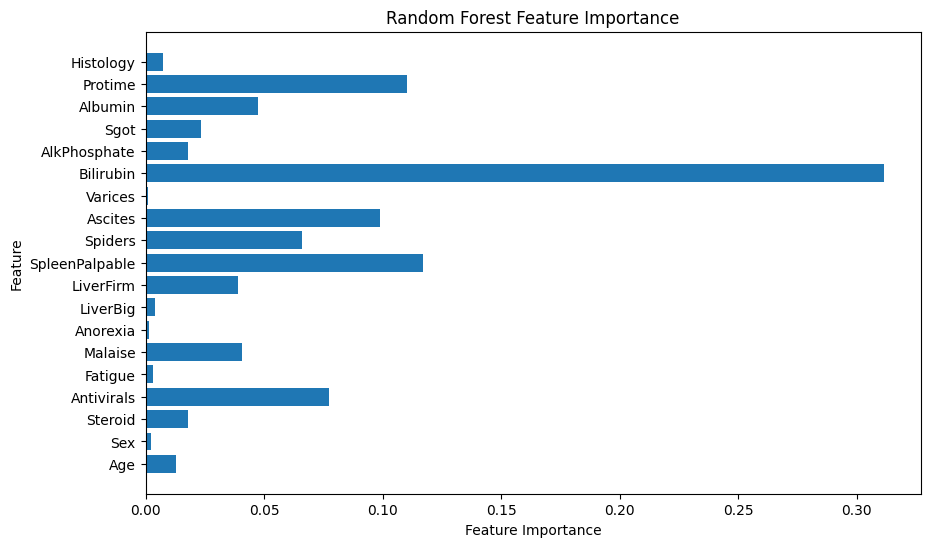

In [ ]:
import matplotlib.pyplot as plt

feature_importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()

In [ ]:
def predict_severity(new_data):
    # Ensure the new_data has the same columns as the training data
    # Example: new_data should be a dictionary or list with values for each feature (excluding 'Class')
    # For example: {'Age': 45, 'Sex': 1, 'Steroid': 0, 'Fatigue': 1, ...}

    # Convert the new data into a DataFrame (assuming new_data is a dictionary)
    new_data_df = pd.DataFrame([new_data])

    # Encode categorical features the same way as in the training data
    for column in new_data_df.select_dtypes(include=['object']).columns:
        le = label_encoders[column]  # Use the pre-fitted LabelEncoder from the training phase
        new_data_df[column] = le.transform(new_data_df[column])

    # Scale the new data
    new_data_scaled = scaler.transform(new_data_df)

    # Predict using the trained model
    severity_prediction = rf_model.predict(new_data_scaled)

    # Convert the numeric prediction back to the corresponding severity class
    severity_class = severity_encoder.inverse_transform(severity_prediction)

    return severity_class[0]


In [ ]:
# Example input data
new_patient = {
    'Age': 35,
    'Sex': 1,  # Male
    'Steroid': 0,  # Not using steroids
    'Antivirals': 0,  # Not on antivirals
    'Fatigue': 0,  # No fatigue
    'Malaise': 0,  # No malaise
    'Anorexia': 0,  # No anorexia
    'LiverBig': 0,  # No liver enlargement
    'LiverFirm': 0,  # Liver is not firm
    'SpleenPalpable': 0,  # Spleen is not palpable
    'Spiders': 0,  # No spider angiomata
    'Ascites': 0,  # No ascites
    'Varices': 0,  # No varices
    'Bilirubin': 0.5,  # Normal bilirubin
    'AlkPhosphate': 90,  # Normal AlkPhosphate
    'Sgot': 20,  # Normal Sgot
    'Albumin': 4.5,  # Normal Albumin
    'Protime': 12,  # Normal Protime
    'Histology': 0  # No abnormal histology
}

# Call the function to predict the severity
predicted_severity = predict_severity(new_patient)
print(f"Predicted Hepatitis Severity: {predicted_severity}")


Predicted Hepatitis Severity: Mild


**SET OF INPUTS**


In [ ]:
mild_patient = {
    'Age': 35,
    'Sex': 1,  # Male
    'Steroid': 0,  # Not using steroids
    'Antivirals': 0,  # Not on antivirals
    'Fatigue': 0,  # No fatigue
    'Malaise': 0,  # No malaise
    'Anorexia': 0,  # No anorexia
    'LiverBig': 0,  # No liver enlargement
    'LiverFirm': 0,  # Liver is not firm
    'SpleenPalpable': 0,  # Spleen is not palpable
    'Spiders': 0,  # No spider angiomata
    'Ascites': 0,  # No ascites
    'Varices': 0,  # No varices
    'Bilirubin': 0.5,  # Normal bilirubin
    'AlkPhosphate': 90,  # Normal AlkPhosphate
    'Sgot': 20,  # Normal Sgot
    'Albumin': 4.5,  # Normal Albumin
    'Protime': 12,  # Normal Protime
    'Histology': 0  # No abnormal histology
}


In [ ]:
  severe_patient = {
    'Age': 65,
    'Sex': 1,  # Male
    'Steroid': 1,  # Using steroids
    'Antivirals': 1,  # On antivirals
    'Fatigue': 1,  # Severe fatigue
    'Malaise': 1,  # Severe malaise
    'Anorexia': 1,  # Severe anorexia
    'LiverBig': 1,  # Liver significantly enlarged
    'LiverFirm': 1,  # Liver is firm (fibrosis/cirrhosis)
    'SpleenPalpable': 1,  # Spleen is palpable (sign of liver disease)
    'Spiders': 1,  # Presence of spider angiomata
    'Ascites': 1,  # Ascites present (fluid accumulation)
    'Varices': 1,  # Varices present (varicose veins in the esophagus)
    'Bilirubin': 3.5,  # High bilirubin (indicating liver dysfunction)
    'AlkPhosphate': 250,  # Elevated AlkPhosphate (indicating liver injury)
    'Sgot': 150,  # Elevated Sgot (indicating liver damage)
    'Albumin': 2.8,  # Low albumin (poor liver function)
    'Protime': 20,  # Elevated protime (blood clotting issues)
    'Histology': 3  # Severe liver damage (e.g., cirrhosis)
}
